In [1]:
import os
from dataclasses import dataclass

import numpy as np

import networkx as nx

import pytorch_lightning as pl
import torch

from tensordict import TensorDict
from torch.utils.data import DataLoader

from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from causica.datasets.causica_dataset_format import DataEnum, load_data
from causica.datasets.tensordict_utils import tensordict_shapes
from causica.distributions import (
    AdjacencyDistribution,
    ContinuousNoiseDist,
    DistributionModule,
    ENCOAdjacencyDistributionModule,
    GibbsDAGPrior,
    JointNoiseModule,
    SEMDistributionModule,
    create_noise_modules,
)
from causica.functional_relationships import ICGNN
from causica.graph.dag_constraint import calculate_dagness
from causica.training.auglag import AugLagLossCalculator, AugLagLR, AugLagLRConfig

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

DATASET_PATH = "https://azuastoragepublic.blob.core.windows.net/datasets"

In [2]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Chapter 14

**Causal discovery and machine learning – from discovery to end-to-end process & beyond**



In [286]:
# Set random seed
SEED = 11
np.random.seed(SEED)

## Data

In [287]:
nx.__version__

'2.8.7'

In [320]:
# Generate a scale-free adjacency matrix
adj_matrix = DAG.scale_free(
    n_nodes=4,
    n_edges=6,
    seed=SEED
)

# Generate the simulation
dataset = IIDSimulation(
    W=adj_matrix, 
    n=5000, 
    method='nonlinear', 
    sem_type='mim'
)

2023-04-07 16:07:23,204 - C:\Users\aleks\anaconda3\envs\causal_book_py39_exprmnt\lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


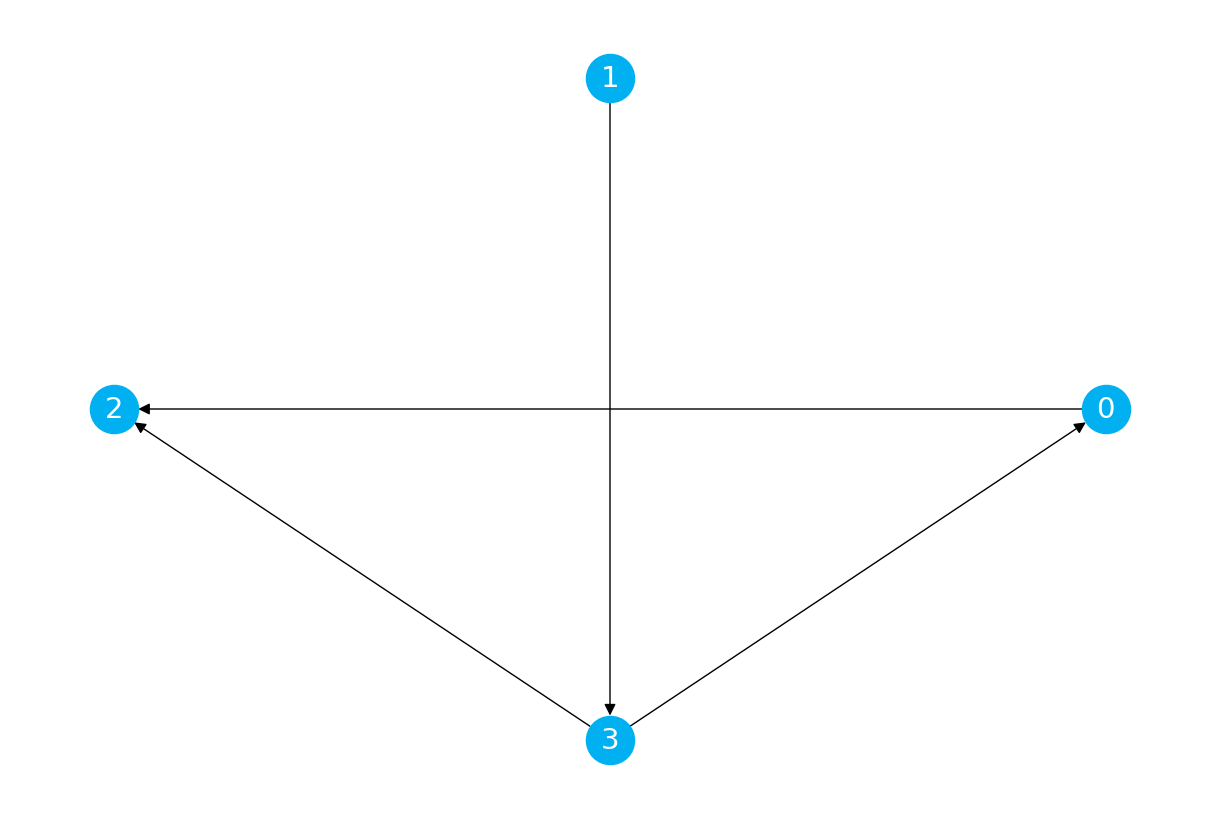

In [321]:
g = nx.DiGraph(adj_matrix)

plt.figure(figsize=(12, 8))
nx.draw(
    G=g,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

In [322]:
@dataclass(frozen=True)
class TrainingConfig:
    noise_dist: ContinuousNoiseDist = ContinuousNoiseDist.SPLINE
    batch_size: int = 256
    max_epoch: int = int(os.environ.get("MAX_EPOCH", 200))  # used by testing to run the notebook as a script
    gumbel_temp: float = 0.25
    averaging_period: int = 10
    prior_sparsity_lambda: float = 4.0
    init_rho: float = 1.0
    init_alpha: float = 0.0


training_config = TrainingConfig()
auglag_config = AugLagLRConfig()
# dataset = "csuite_nonlin_simpson"

pl.seed_everything(SEED)  # set the random seed
device = "cuda" if torch.cuda.is_available() else "cpu"

Global seed set to 11


In [323]:

dataset_name = "csuite_nonlin_simpson"
root_path = os.path.join(DATASET_PATH, dataset_name)
variables_metadata = load_data(root_path, DataEnum.VARIABLES_JSON)
# dataset_train: TensorDict = load_data(root_path, DataEnum.TRAIN, variables_metadata)
    
data_tensors = {}

for i in range(dataset.X.shape[1]):
    data_tensors[f'x{i}'] = torch.tensor(dataset.X[:, i].reshape(-1, 1))
    
dataset_train = TensorDict(data_tensors, torch.Size([dataset.X.shape[0]]))
    
# move the entire dataset to the device, since it is small
dataset_train = dataset_train.apply(lambda t: t.to(dtype=torch.float32, device=device))

dataloader_train = DataLoader(
    dataset=dataset_train,
    collate_fn=lambda x: x,
    batch_size=training_config.batch_size,
    shuffle=True,
    drop_last=False,
)

In [324]:
dataset_train

TensorDict(
    fields={
        x0: Tensor(shape=torch.Size([5000, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x1: Tensor(shape=torch.Size([5000, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x2: Tensor(shape=torch.Size([5000, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x3: Tensor(shape=torch.Size([5000, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([5000]),
    device=None,
    is_shared=False)

In [325]:
# keys = [key for key in dataset_train.keys()]
# n_vars = len(keys)

# plot = 1

# plt.figure(figsize=(30, 15))

# for i in range(n_vars):
#     for j in range(i + 1, n_vars):
#         if i < n_vars - 1:
#             plt.subplot(2, 3, plot)
#             plt.scatter(
#                 dataset_train[keys[i]],
#                 dataset_train[keys[j]],
#                 alpha=.2
#             )
#             plt.xlabel(keys[i])
#             plt.ylabel(keys[j])
#         plot += 1

In [326]:
num_nodes = len(dataset_train.keys())
prior = GibbsDAGPrior(num_nodes=num_nodes, sparsity_lambda=training_config.prior_sparsity_lambda)

In [327]:
adjacency_dist: DistributionModule[AdjacencyDistribution] = ENCOAdjacencyDistributionModule(num_nodes)

In [328]:
icgnn = ICGNN(
    variables=tensordict_shapes(dataset_train),
    embedding_size=32, #32,
    out_dim_g=32, #32,
    norm_layer=torch.nn.LayerNorm,
    res_connection=True,
)

In [329]:
variable_shapes = tensordict_shapes(dataset_train)

# Get type
type_continuous = variables_metadata['variables'][0]

types_dict = {var_name: type_continuous['type'] for var_name in dataset_train.keys()}

noise_submodules = create_noise_modules(variable_shapes, types_dict, training_config.noise_dist)
noise_module = JointNoiseModule(noise_submodules)

In [330]:
sem_module: SEMDistributionModule = SEMDistributionModule(adjacency_dist, icgnn, noise_module)
sem_module.to(device)

SEMDistributionModule(
  (adjacency_module): ENCOAdjacencyDistributionModule()
  (functional_relationships): ICGNN(
    (nn): FGNNI(
      (g): Sequential(
        (0): Sequential(
          (0): Linear(in_features=36, out_features=64, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=64, out_features=64, bias=True)
            (2): LeakyReLU(negative_slope=0.01)
          )
        )
        (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=64, out_features=32, bias=True)
        (4): Identity()
      )
      (f): Sequential(
        (0): _ResBlock(
          (block): Sequential(
            (0): Linear(in_features=64, out_features=64, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
          )
        )
        (1): _ResBlock(
          (block): Sequential(
 

In [331]:
modules = {
    "icgnn": sem_module.functional_relationships,
    "vardist": sem_module.adjacency_module,
    "noise_dist": sem_module.noise_module,
}
parameter_list = [
    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
    for name, module in modules.items()
]

optimizer = torch.optim.Adam(parameter_list)

In [332]:
scheduler = AugLagLR(config=auglag_config)
auglag_loss = AugLagLossCalculator(init_alpha=training_config.init_alpha, init_rho=training_config.init_rho)

epoch:0 loss:7.8641 nll:7.8623 dagness:1.08616 num_edges:4 alpha:0 rho:1 step:0|1 num_lr_updates:0


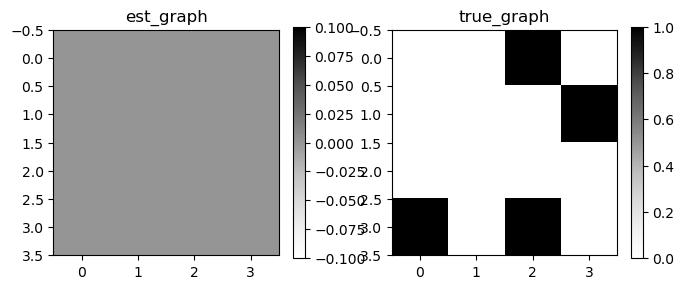

epoch:10 loss:6.2173 nll:6.2132 dagness:0.00000 num_edges:6 alpha:0 rho:1 step:0|201 num_lr_updates:0


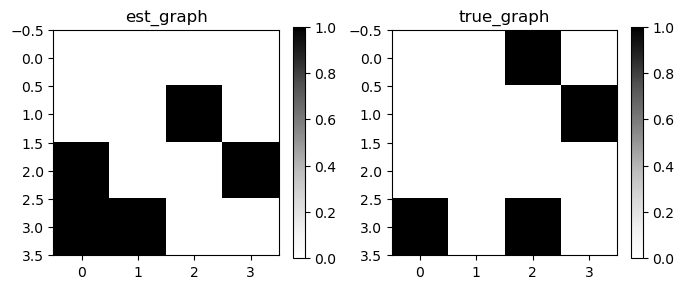

epoch:20 loss:6.3178 nll:6.3127 dagness:1.63362 num_edges:7 alpha:0 rho:1 step:0|401 num_lr_updates:0


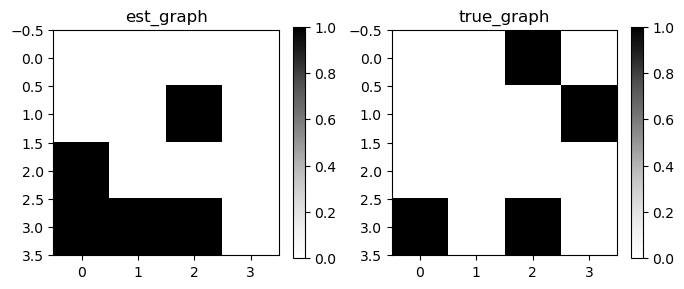

epoch:30 loss:6.7838 nll:6.7792 dagness:1.63362 num_edges:6 alpha:0 rho:1 step:0|601 num_lr_updates:1


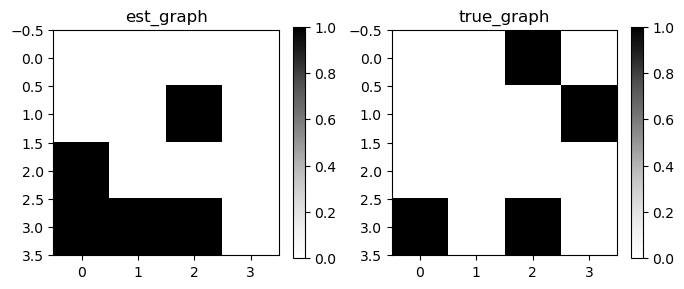

Updating alpha to: 0.0
epoch:40 loss:7.6862 nll:7.6825 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:1|10 num_lr_updates:0


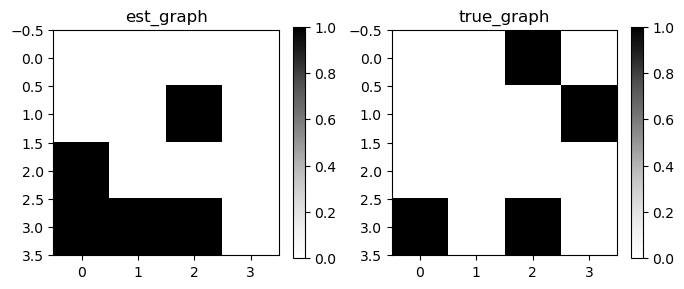

epoch:50 loss:9.9286 nll:9.9248 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:1|210 num_lr_updates:0


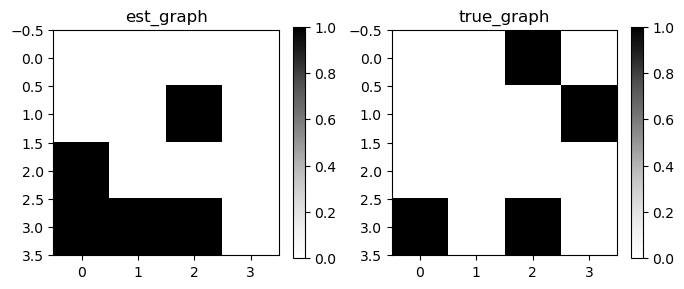

epoch:60 loss:9.8305 nll:9.8267 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:1|410 num_lr_updates:0


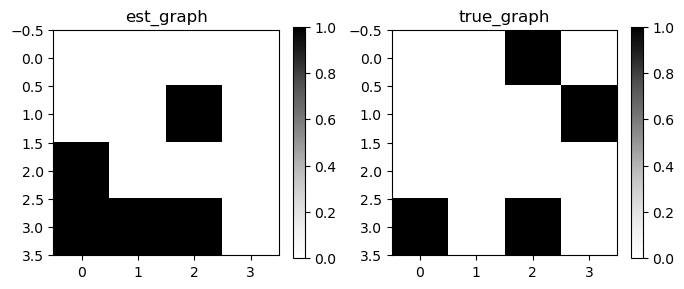

Updating alpha to: 0.0
epoch:70 loss:10.824 nll:10.821 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:2|31 num_lr_updates:0


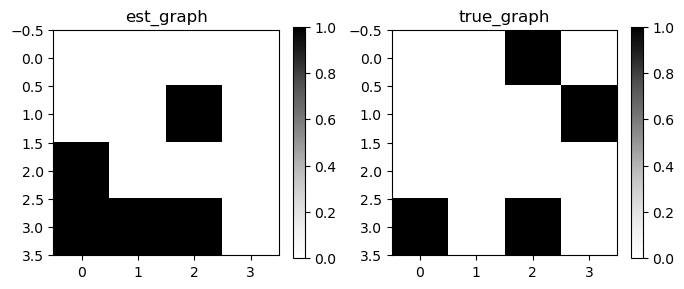

epoch:80 loss:10.852 nll:10.848 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:2|231 num_lr_updates:0


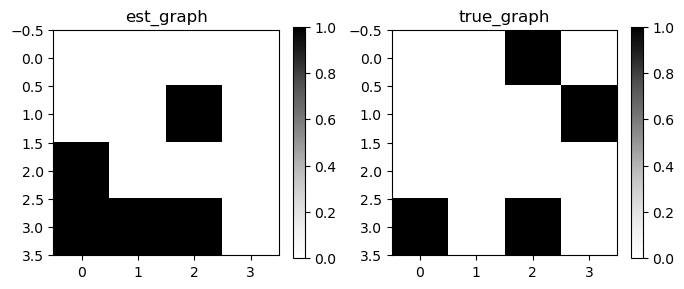

epoch:90 loss:11.435 nll:11.431 dagness:0.00000 num_edges:6 alpha:0 rho:1 step:2|431 num_lr_updates:0


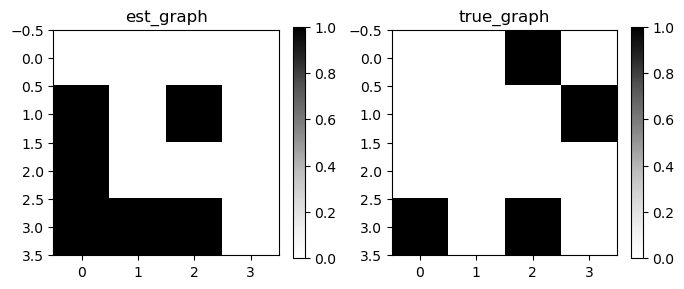

epoch:100 loss:11.619 nll:11.614 dagness:1.08616 num_edges:7 alpha:0 rho:1 step:2|631 num_lr_updates:1


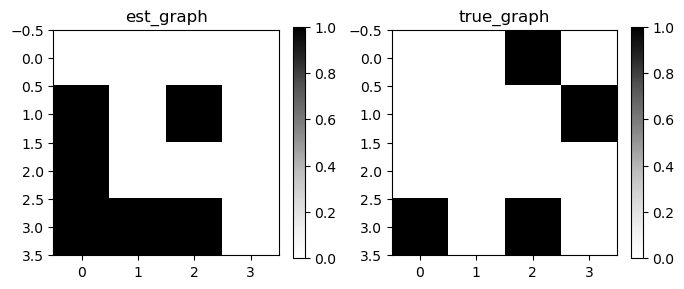

Updating alpha to: 0.0
epoch:110 loss:11.568 nll:11.563 dagness:0.00000 num_edges:6 alpha:0 rho:1 step:3|111 num_lr_updates:0


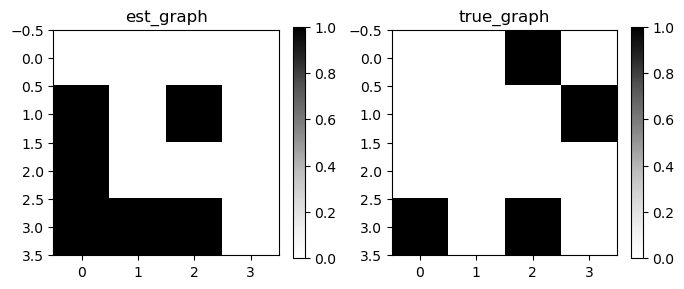

epoch:120 loss:11.258 nll:11.255 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:3|311 num_lr_updates:0


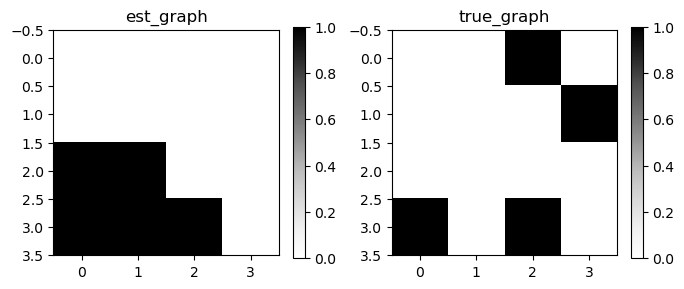

epoch:130 loss:10.497 nll:10.493 dagness:0.00000 num_edges:6 alpha:0 rho:1 step:3|511 num_lr_updates:1


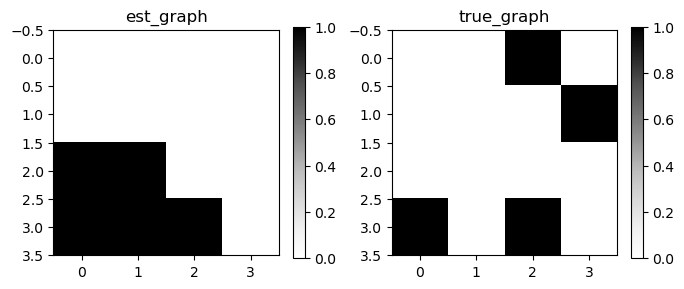

epoch:140 loss:10.336 nll:10.333 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:3|711 num_lr_updates:1


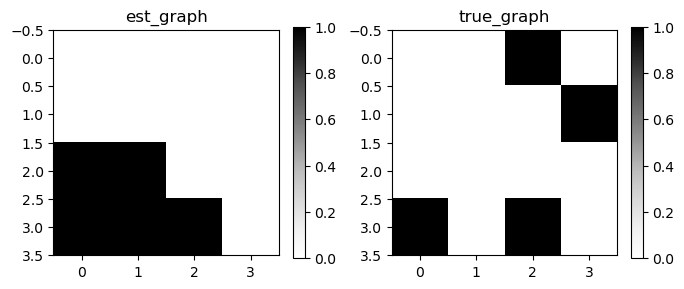

epoch:150 loss:10.181 nll:10.177 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:3|911 num_lr_updates:1


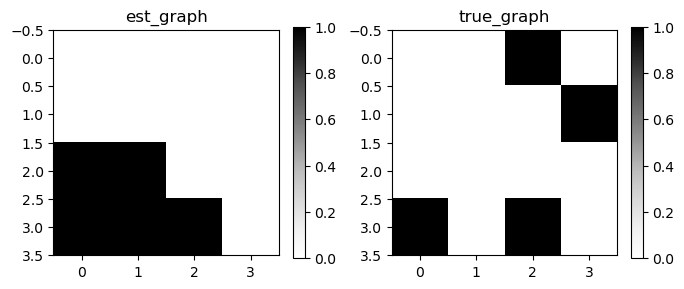

epoch:160 loss:10.44 nll:10.436 dagness:0.00000 num_edges:6 alpha:0 rho:1 step:3|1111 num_lr_updates:2


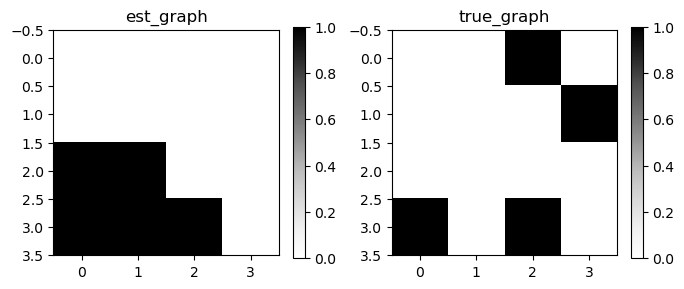

Updating alpha to: 0.0
epoch:170 loss:9.5476 nll:9.5448 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:4|29 num_lr_updates:0


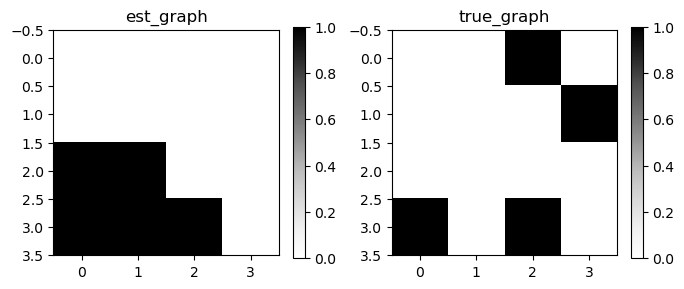

epoch:180 loss:10.902 nll:10.897 dagness:1.08616 num_edges:6 alpha:0 rho:1 step:4|229 num_lr_updates:0


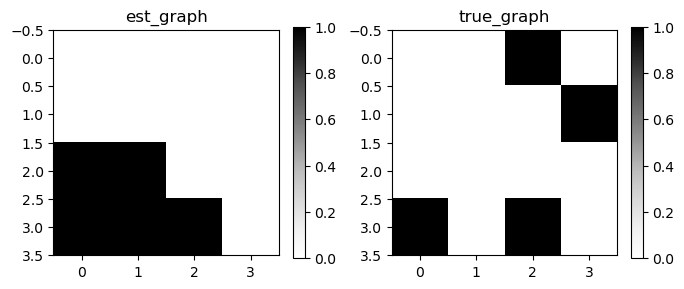

epoch:190 loss:11.59 nll:11.585 dagness:1.08616 num_edges:6 alpha:0 rho:1 step:4|429 num_lr_updates:0


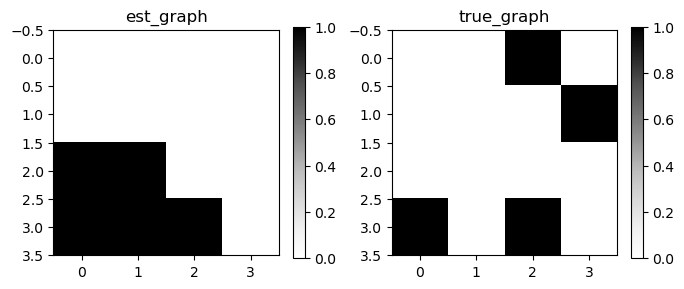

Updating rho, dag penalty prev:  0.0000000000


In [333]:
assert len(dataset_train.batch_size) == 1, "Only 1D batch size is supported"
num_samples = len(dataset_train)
for epoch in range(training_config.max_epoch):
    for i, batch in enumerate(dataloader_train):
        optimizer.zero_grad()
        sem_distribution = sem_module()
        sem, *_ = sem_distribution.relaxed_sample(
            torch.Size([]), temperature=training_config.gumbel_temp
        )  # soft sample

        batch_log_prob = sem.log_prob(batch).mean()
        sem_distribution_entropy = sem_distribution.entropy()
        prior_term = prior.log_prob(sem.graph)
        objective = (-sem_distribution_entropy - prior_term) / num_samples - batch_log_prob
        constraint = calculate_dagness(sem.graph)

        loss = auglag_loss(objective, constraint / num_samples)

        loss.backward()
        optimizer.step()
        # update the Auglag parameters
        scheduler.step(
            optimizer=optimizer,
            loss=auglag_loss,
            loss_value=loss.item(),
            lagrangian_penalty=constraint.item(),
        )
        # log metrics
        if epoch % 10 == 0 and i == 0:
            print(
                f"epoch:{epoch} loss:{loss.item():.5g} nll:{-batch_log_prob.detach().cpu().numpy():.5g} "
                f"dagness:{constraint.item():.5f} num_edges:{(sem.graph > 0.0).sum()} "
                f"alpha:{auglag_loss.alpha:.5g} rho:{auglag_loss.rho:.5g} "
                f"step:{scheduler.outer_opt_counter}|{scheduler.step_counter} "
                f"num_lr_updates:{scheduler.num_lr_updates}"
            )
            
            vardist = adjacency_dist()
            pred_dag = vardist.mode.cpu().numpy()

            plt.style.use('default')

            GraphDAG(
                est_dag=pred_dag, 
                true_dag=adj_matrix)

            plt.show()

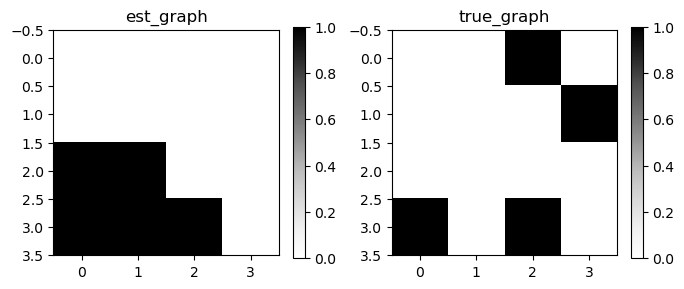

In [334]:
vardist = adjacency_dist()
pred_dag = vardist.mode.cpu().numpy()

plt.style.use('default')

GraphDAG(
    est_dag=pred_dag, 
    true_dag=adj_matrix)

plt.show()

In [303]:
metrics = MetricsDAG(
    B_est=pred_dag, 
    B_true=adj_matrix)

C:\Users\aleks\anaconda3\envs\causal_book_py39_exprmnt\lib\site-packages\castle\metrics\evaluation.py:226: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*(recall*precision)/(recall+precision)


In [304]:
metrics.metrics

{'fdr': 1.0,
 'tpr': 0.0,
 'fpr': 1.5,
 'shd': 5,
 'nnz': 3,
 'precision': 0.0,
 'recall': 0.0,
 'F1': nan,
 'gscore': 0.0}

Text(0.5, 1.0, 'Learned')

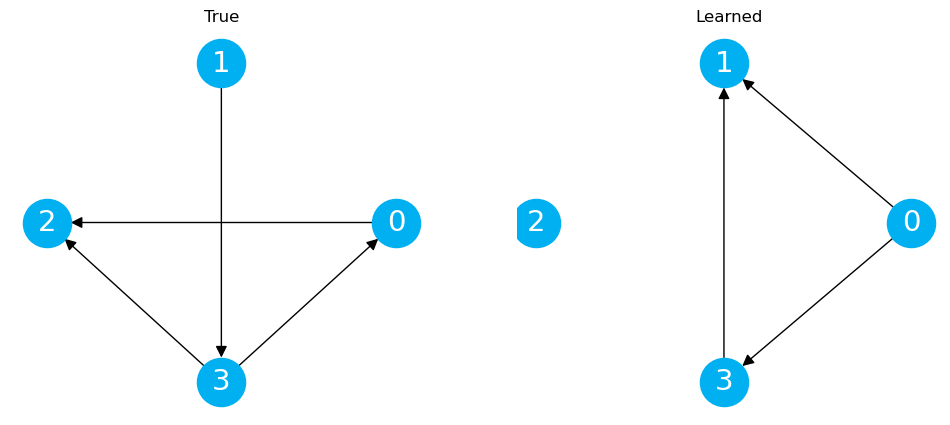

In [305]:
g = nx.DiGraph(adj_matrix)

plt.figure(figsize=(12, 5))

plt.subplot(121)
nx.draw(
    G=g,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)
plt.title('True')

plt.subplot(122)
nx.draw(
    G=nx.DiGraph(pred_dag),
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(nx.DiGraph(pred_dag))
)
plt.title('Learned')